In [2]:
import os
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib import cm
from math import ceil

In [3]:
def count_folders_starting_with(path, prefix):
    folders = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder)) and folder.startswith(prefix)]
    return len(folders)

def get_folder_names(path):
    folder_names = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    return folder_names

def case_info(setups):
    E_iso = setups['E_iso']
    L_d = setups['luminosity distance']
    jet = setups['jet type']
    theta_c = setups['theta_core']
    n_ism = setups['n_ism']
    eps_e = setups['epsilon_e']
    eps_b = setups['epsilon_B']
    p = setups['p']
    theta_obs = setups['theta_view']
    band_pass = setups['band pass (kev)']

    info1 = "$E_{\\rm iso} = 10^{%.1lf}$ erg, $L_d = 10^{%.1lf}$ cm, $n_{\\rm ism}= 10^{%.1lf}$ cm$^{-3}$\n"%(np.log10(E_iso), np.log10(L_d), np.log10(n_ism))
    info2 = "$\\theta_c = %.1lf^\\circ$, $\\epsilon_e=10^{%.1lf}, \\epsilon_B=10^{%.1lf}, p = %.3lf$\n"%(theta_c*180/np.pi, np.log10(eps_e), np.log10(eps_b), p)
    info3 = " $\\theta_{\\rm view}=%.1lf ^\\circ$, bandpass [%.1lf,%.1lf] keV"%(theta_obs*180/np.pi, band_pass[0], band_pass[1])
    
    return jet+"\n"+info1+info2+info3    

def find_average(t, light_curves):
    from scipy.interpolate import interp1d
    y_interpolated = []
    for (x, y) in light_curves:
        f = interp1d(x, y, bounds_error=False, fill_value="extrapolate")
        y_interp = f(t)
        y_interpolated.append(y_interp)
    y_interpolated = np.array(y_interpolated)
    y_average = np.mean(y_interpolated, axis=0)
    return y_average

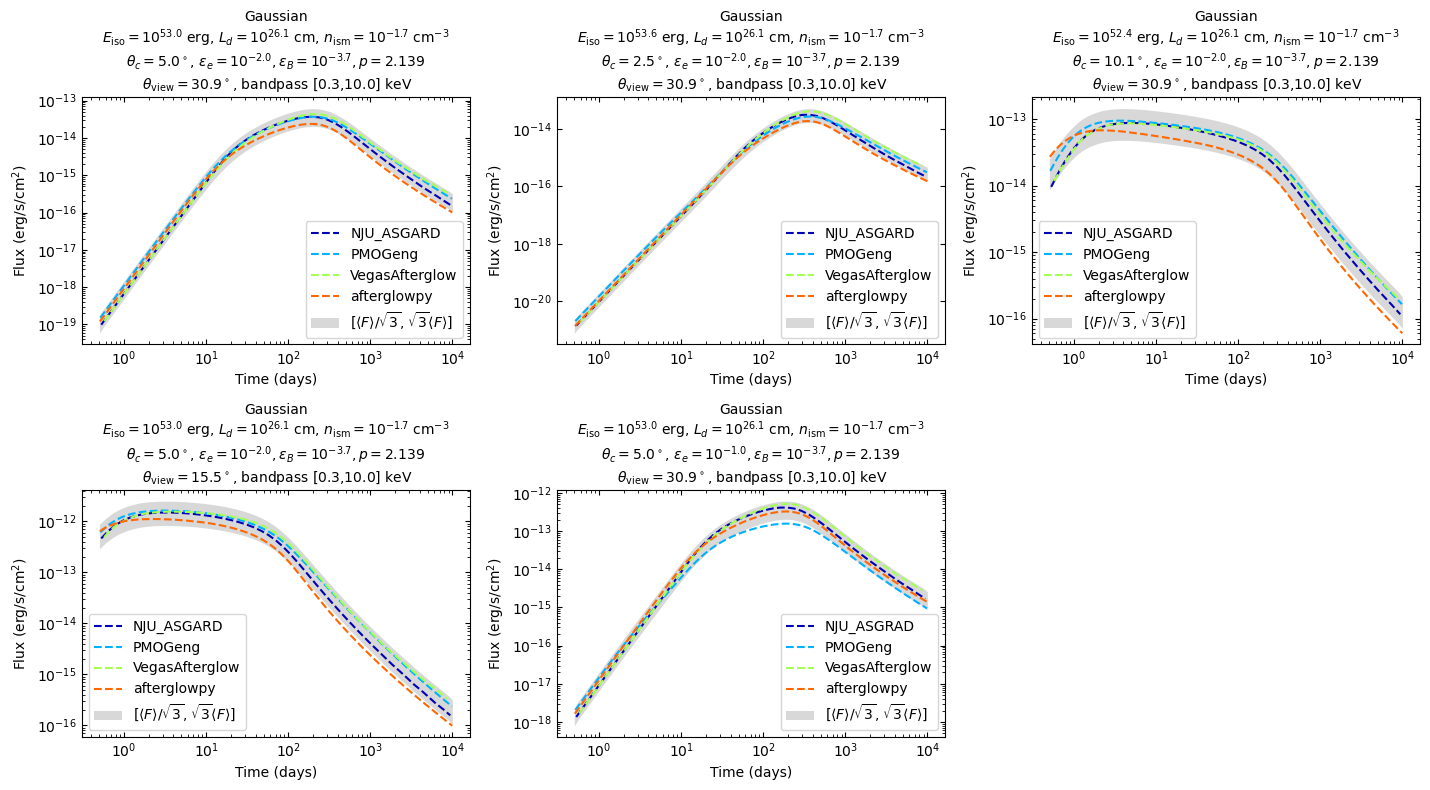

In [4]:
def draw_comparison():
    case_num = count_folders_starting_with('tests/', 'case')
    day = 24*3600

    col_num = 3
    row_num = int(ceil(case_num / col_num))
    
    plt.figure(figsize=(4.8*col_num, 4*row_num))

    axs = [plt.subplot(row_num, col_num, i+1) for i in range(case_num)]
    
    for i in range(case_num):
        path = 'tests/case'+str(i+1)+'/'
        with open(path+'/problem-setups.json') as json_file:
            setups = json.load(json_file)
        info = case_info(setups)

        code_names = get_folder_names(path)
        code_names.sort()
        line_colors = cm.jet(np.linspace(0.05, 0.8, len(code_names)))

        light_curves = []
        
        for code_name, color in zip(code_names, line_colors):
            flux = np.loadtxt(path+code_name+'/flux.csv',delimiter=',')
            t_obs = flux[:,0]/day
            flux = flux[:,1:]
            mask = (t_obs > 0.5) & (t_obs < 1e4)

            axs[i].loglog(t_obs[mask], flux[mask], label=code_name, color=color,ls='--')

            light_curves.append((t_obs[mask], flux[mask][:,0]))
            
        t_new = np.logspace(np.log10(0.5),4,100)
        ave = find_average(t_new, light_curves)
        axs[i].fill_between(t_new, ave/np.sqrt(3), ave*np.sqrt(3), color='gray', alpha=0.3, lw=0,label=r'[$\langle F \rangle/\sqrt{3}$, $\sqrt{3}\langle F \rangle$]')
        #axs[i].set_xlim(setups['t_obs'][0]/day, setups['t_obs'][1]/day)
        #axs[i].set_ylim(1e-21, 1e-11)
        axs[i].set_title(info,fontsize=10)

        axs[i].set_xlabel('Time (days)')
        axs[i].set_ylabel('Flux (erg/s/cm$^2$)')
        axs[i].legend(loc='best')
        axs[i].tick_params(axis='both', which='both', direction='in', top=True, right=True)
    plt.tight_layout()
    plt.savefig('code-comparison.pdf', dpi=500, bbox_inches='tight')

draw_comparison()